## Output has been removed from this notebook to reduce file sizes in the repo

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import pandana as pdna
import geopandas.io.osm as osm
%matplotlib inline

C:\Users\spm448\Anaconda\DLLs


## Download OpenStreetMap restaurants for a good part of the Bay Area

###### Note: used http://boundingbox.klokantech.com/ to get the bounding box

In [2]:
gdf = osm.query_osm('node', 
                    bbox=[-122.8662,37.1373,-121.4798,38.2158],
                    tags='amenity=fire_station')

In [3]:
gdf = gdf[gdf.type == 'Point'].to_crs(epsg=3740)
print gdf.geometry.head(3)
print len(gdf)

0      POINT (570106.425976538 4186530.13166448)
1    POINT (604695.3525471315 4172719.445738724)
2    POINT (551608.2769317736 4160852.569819334)
Name: geometry, dtype: object
188


In [4]:
x, y = zip(*[(p.x, p.y) for (i, p) 
             in gdf.geometry.iteritems()])
x = pd.Series(x)
y = pd.Series(y)

## Get OpenStreetMap networks for Bay Area that I had previously - someday soon we'll have direct OSM import

In [5]:
store = pd.HDFStore('data/osm_bayarea.h5', "r")
nodes = store.nodes
edges = store.edges
print nodes.head(3)
print edges.head(3)

              x           y
8   629310.1250  4095536.75
9   629120.9375  4095816.75
10  628951.5625  4096090.50
   from  to      weight
6     8   9  338.255005
7     9  10  322.532990
8    10  11  218.505997


## Initialize and preprocess the network

In [6]:
net=pdna.Network(nodes.x, 
                       nodes.y, 
                       edges["from"], 
                       edges.to, 
                       edges[["weight"]])
net.precompute(3000)

## Nearest *point-of-interest* queries

In [7]:
net.init_pois(num_categories=3, max_dist=3000, max_pois=10)

In [8]:
net.set_pois("fire_stations", x, y)

In [9]:
a = net.nearest_pois(3000, "fire_stations", num_pois=10)
print a.head(1)

     1     2     3     4     5     6     7     8     9     10
8  3000  3000  3000  3000  3000  3000  3000  3000  3000  3000


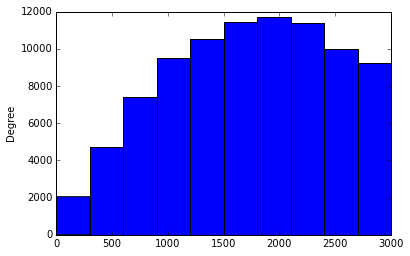

In [26]:
c = a[a.columns[0]]
c = c[c < 3000]
c.plot(kind = 'hist')

In [10]:
from shapely.geometry import Point
from fiona.crs import from_epsg
import geopandas as gpd
bbox=[-122.539365,37.20000,-122.347698,37.816069]
bbox = gpd.GeoSeries([Point(bbox[0], bbox[1]),
                      Point(bbox[2], bbox[3])], 
                     crs=from_epsg(4326))
bbox = bbox.to_crs(epsg=3740)
bbox = [bbox[0].x, bbox[0].y, bbox[1].x, bbox[1].y]

## Here's a map of the distance to the nearest restaurant

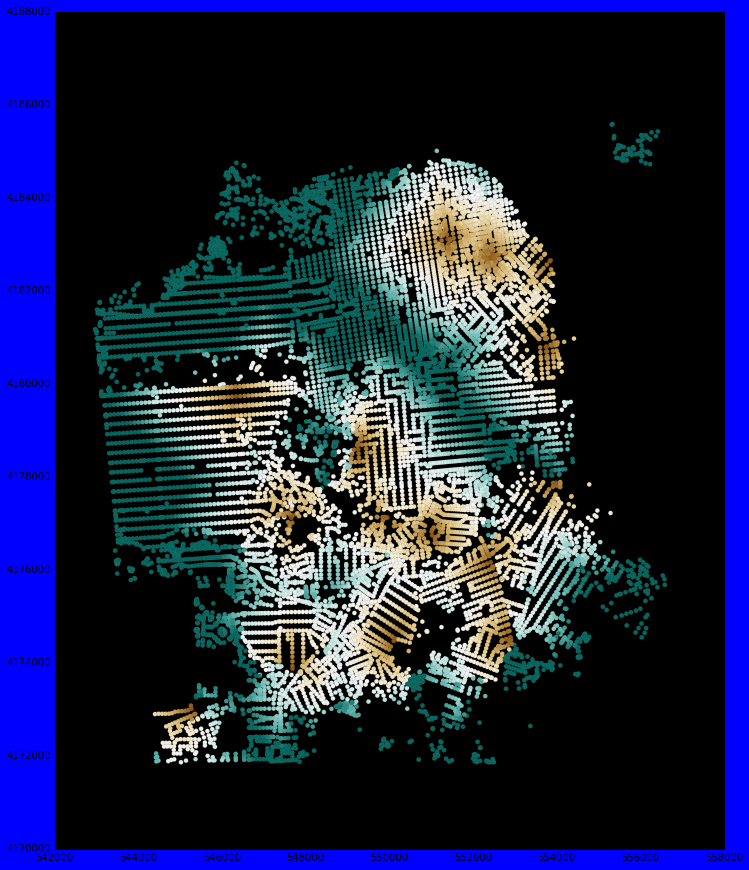

In [11]:
net.plot(a[1], bbox=bbox, scheme="diverging", 
         color="BrBG")

## Here's a map of the distance to the 5th nearest restaurant

In [ ]:
net.plot(a[5], bbox=bbox, scheme="diverging", 
         color="BrBG")

## Here's a map of the distance to the 10th nearest restaurant

In [ ]:
net.plot(a[10], bbox=bbox, scheme="diverging", 
         color="BrBG")

# A similar workflow is used to do general network aggregations

## Relate the x-ys to nodes

In [12]:
node_ids = net.get_node_ids(x, y)

## Assign the variable (in this case just location) to the network

In [13]:
net.set(node_ids)

## This is it - run the queries!

In [14]:
%time s = net.aggregate(500, type="sum", decay="linear")
%time t = net.aggregate(1000, type="sum", decay="linear")
%time u = net.aggregate(2000, type="sum", decay="linear")
%time v = net.aggregate(3000, type="sum", decay="linear")
%time w = net.aggregate(3000, type="count", decay="flat")

Wall time: 3.19 s
Wall time: 517 ms
Wall time: 850 ms
Wall time: 1.14 s
Wall time: 1.19 s


## Here's a map of access to restaurants with a 500m radius

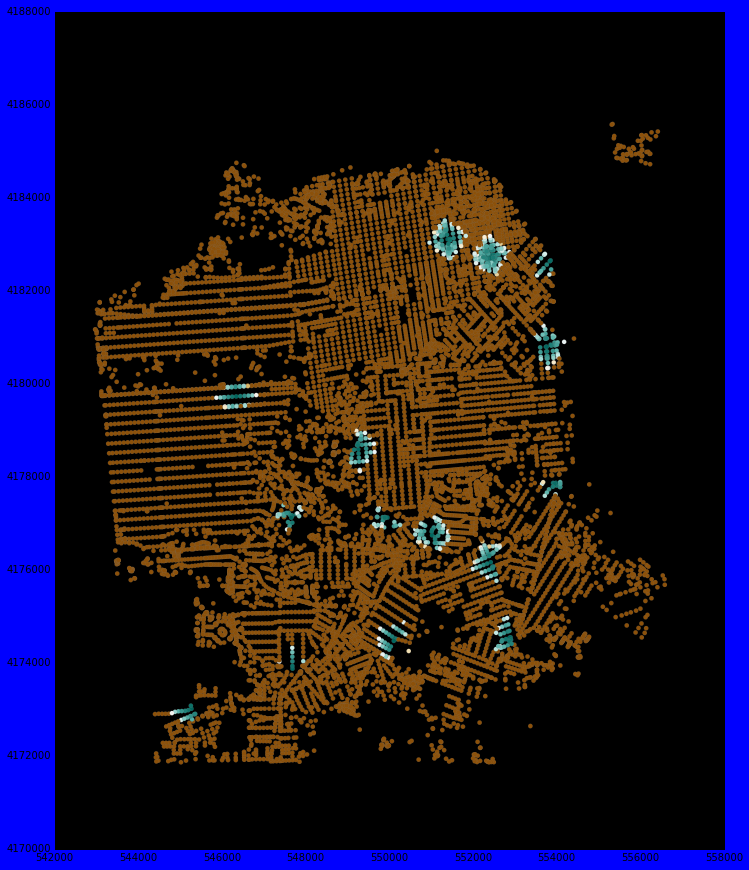

In [15]:
net.plot(s, bbox=bbox, scheme="diverging", 
         color="BrBG", log_scale=True)

## Or 1000 meters

In [ ]:
net.plot(t, bbox=bbox, scheme="diverging", 
         color="BrBG", log_scale=True)

## Or 2000 meters radius

In [ ]:
net.plot(u, bbox=bbox, scheme="diverging", 
         color="BrBG", log_scale=True)

## Or 3000m radius

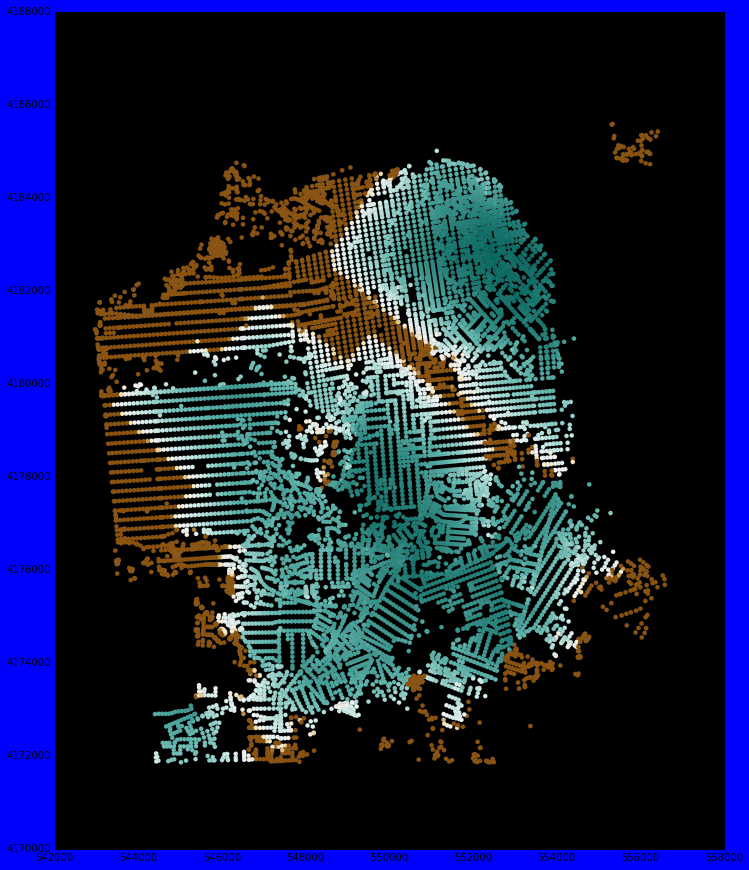

In [16]:
net.plot(v, bbox=bbox, scheme="diverging", 
         color="BrBG", log_scale=True)

## Or the whole Bay Area region - someone please help me with this visualization!

In [ ]:
net.plot(v, scheme="diverging", 
         color="BrBG", log_scale=True)